In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Parameters

In [2]:
TF2 = 2
TF3 = 3
NTest = 96
NVal = 100
T1 = 30
D = 15

In [3]:
def split_X_Y(ar, T, TF):
  X = []
  Y = []
  for t in range(len(ar) - T - TF + 1):
    x = ar[t : t + T, 0: -1]
    X.append(x)
    y = ar[t + T : t + T + TF, -1:]
    Y.append(y)

  X = np.array(X).astype(float) 
  if TF == 1:
    Y = np.array(Y).astype(float).reshape(len(Y), )
  else:
    Y = np.array(Y).astype(float).reshape(len(Y), TF)
  print("X.shape", X.shape, "Y.shape", Y.shape) 
  return X, Y

In [4]:
def feature_selection(x_train, y_train):
  rfe = RFE(RandomForestRegressor(), n_features_to_select=18)
  fit = rfe.fit(x_train.reshape(len(x_train),D*T1), y_train)
  important_features = list()
  for i in range(len(fit.support_)):
      if fit.support_[i]:
          important_features.append(i)
  result = np.array(important_features)
  calMostFeature = [0]*D
  for i in result:
    calMostFeature[i%D] = calMostFeature[i%D] + 1
  print(calMostFeature)
  # top_idx =  np.sort(np.argsort(calMostFeature)[-NFeature:])
  return calMostFeature

In [5]:
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error, r2_score
from statistics import mean 

In [6]:
def split_y_y(y):
    y_0 = []
    y_1 = []
    for i in range(0, len(y)):
        y_0.append(y[i][0])
        y_1.append(y[i][1])
    return np.array(y_0), np.array(y_1)

In [7]:
def deviation_function(y, pred):
  deviation_0 = []
  deviation_1 = []
  for i in range(0, len(y)):
      deviation_0.append(abs(pred[i][0] - y[i][0]) / y[i][0])
      deviation_1.append(abs(pred[i][1] - y[i][1]) / y[i][1])
  return (mean(deviation_0) + mean(deviation_1))/TF2
def deviation_function_inv(y, pred):
  deviation_0 = []
  deviation_1 = []
  for i in range(0, len(y)):
      deviation_0.append(abs(pred[i][0] - y[i][0]) / y[i][0])
      deviation_1.append(abs(pred[i][1] - y[i][1]) / y[i][1])
  return ((np.array(deviation_0).mean()) + (np.array(deviation_1).mean()))/TF2

In [8]:
def deviation_function_sarimax(y, pred_0, pred_1):
  deviation_0 = []
  deviation_1 = []
  for i in range(0, len(y)):
      deviation_0.append(abs(pred_0[i] - y[i][0]) / y[i][0])
      deviation_1.append(abs(pred_1[i] - y[i][1]) / y[i][1])
  return (mean(deviation_0) + mean(deviation_1))/TF2
def deviation_function_sarimax_inv(y, pred_0, pred_1):
  deviation_0 = []
  deviation_1 = []
  for i in range(0, len(y)):
      deviation_0.append(abs(pred_0[i] - y[i][0]) / y[i][0])
      deviation_1.append(abs(pred_1[i] - y[i][1]) / y[i][1])
  return (mean(np.array(deviation_0).mean(axis=1)) + mean(np.array(deviation_1).mean(axis=1)))/TF2

In [9]:
def evaluation(y, pred, name_model):
    #mean squared error
    mse=mean_squared_error(y, pred)     
    #mean absolute error     
    mae=mean_absolute_error(y, pred)  
    #root mean squared error      
    rmse=np.sqrt(mean_squared_error(y, pred))
    #r2 score
    r2 = r2_score(y, pred)
    #deviation
    deviation = deviation_function(y, pred)
    print(f'mse: {mse}')
    print(f'mae: {mae}')
    print(f'rmse: {rmse}')
    print(f"R-Squared: {r2}")
    print(f"Deviation: {deviation}")
    measure_df =pd.DataFrame({"mse": mse,"mae": mae,"rmse": rmse, "r2": r2, 'deviation': deviation},index=[name_model])
    return measure_df
def evaluation_inv(y, pred, name_model):
    #mean squared error
    mse=mean_squared_error(y, pred)     
    #mean absolute error     
    mae=mean_absolute_error(y, pred)  
    #root mean squared error      
    rmse=np.sqrt(mean_squared_error(y, pred))
    #r2 score
    r2 = r2_score(y, pred)
    #deviation
    deviation = deviation_function_inv(y, pred)
    print(f'mse: {mse}')
    print(f'mae: {mae}')
    print(f'rmse: {rmse}')
    print(f"R-Squared: {r2}")
    print(f"Deviation: {deviation}")
    measure_df =pd.DataFrame({"mse": mse,"mae": mae,"rmse": rmse, "r2": r2, 'deviation': deviation},index=[name_model])
    return measure_df

In [10]:
def evalution_sarimax(y, pred_0, pred_1, name_model):
    y_0, y_1 = split_y_y(y)
    #mean squared error
    mse_0 =mean_squared_error(y_0, pred_0)     
    #mean absolute error     
    mae_0 =mean_absolute_error(y_0, pred_0)  
    #root mean squared error      
    rmse_0 =np.sqrt(mean_squared_error(y_0, pred_0))
    #r2 score
    r2_0 = r2_score(y_0, pred_0) 
    
    #mean squared error
    mse_1 =mean_squared_error(y_1, pred_1)     
    #mean absolute error     
    mae_1 =mean_absolute_error(y_1, pred_1)  
    #root mean squared error      
    rmse_1 =np.sqrt(mean_squared_error(y_1, pred_1))
    #r2 score
    r2_1 = r2_score(y_1, pred_1) 

    #mean squared error
    mse =(mse_0 + mse_1) / TF2  
    #mean absolute error     
    mae =(mae_0 + mae_1) / TF2  
    #root mean squared error      
    rmse =(rmse_0 + rmse_1) / TF2  
    #r2 score
    r2 =(r2_0 + r2_1) / TF2  
    #deviation
    deviation = deviation_function_sarimax(y, pred_0, pred_1)

    print(f'mse: {mse}')
    print(f'mae: {mae}')
    print(f'rmse: {rmse}')
    print(f"R-Squared: {r2}")
    print(f"Deviation: {deviation}")
    measure_df =pd.DataFrame({"mse": mse,"mae": mae,"rmse": rmse, "r2": r2, 'deviation': deviation},index=[name_model])
    return measure_df

def evalution_sarimax_inv(y, pred_0, pred_1, name_model):
    y_0, y_1 = split_y_y(y)
    #mean squared error
    mse_0 =mean_squared_error(y_0, pred_0)     
    #mean absolute error     
    mae_0 =mean_absolute_error(y_0, pred_0)  
    #root mean squared error      
    rmse_0 =np.sqrt(mean_squared_error(y_0, pred_0))
    #r2 score
    r2_0 = r2_score(y_0, pred_0) 
    
    #mean squared error
    mse_1 =mean_squared_error(y_1, pred_1)     
    #mean absolute error     
    mae_1 =mean_absolute_error(y_1, pred_1)  
    #root mean squared error      
    rmse_1 =np.sqrt(mean_squared_error(y_1, pred_1))
    #r2 score
    r2_1 = r2_score(y_1, pred_1) 

    #mean squared error
    mse =(mse_0 + mse_1) / TF2  
    #mean absolute error     
    mae =(mae_0 + mae_1) / TF2  
    #root mean squared error      
    rmse =(rmse_0 + rmse_1) / TF2  
    #r2 score
    r2 =(r2_0 + r2_1) / TF2  
    #deviation
    deviation = deviation_function_sarimax_inv(y, pred_0, pred_1)

    print(f'mse: {mse}')
    print(f'mae: {mae}')
    print(f'rmse: {rmse}')
    print(f"R-Squared: {r2}")
    print(f"Deviation: {deviation}")
    measure_df =pd.DataFrame({"mse": mse,"mae": mae,"rmse": rmse, "r2": r2, 'deviation': deviation},index=[name_model])
    return measure_df

# Normalization Dataset

In [11]:
df_normalize = pd.read_csv("G:/My Drive/IS6102.CH1701/Result/Dataset/normalization.csv", parse_dates=['Date'], index_col=0)
df_normalize.head(15)

,Gold_Close,Oil_Close,Volume_Top2,Volume_Top3,Volume_Top4,Volume_Top5,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y
Date,,,,,,,,,,,,,,,,
2020-03-12,0.195054,0.428501,0.252108,0.035745,0.666943,0.028726,0.090175,0.096398,0.215437,0.385386,0.294139,0.478063,0.760187,0.813189,0.055378,0.000000
2020-03-13,0.066875,0.429926,0.236596,0.038759,0.662361,0.030444,0.023122,0.096398,0.145379,0.473294,0.327844,0.241249,0.699492,0.549101,0.038502,0.009472
2020-03-14,0.066875,0.429926,0.224523,0.036015,0.668942,0.030070,0.027929,0.096398,0.153463,0.453264,0.315684,0.060818,0.682915,0.560035,0.160002,0.003668
2020-03-15,0.066875,0.429926,0.241015,0.036838,0.654064,0.026986,0.015865,0.096398,0.129212,0.405045,0.227655,0.267530,0.500701,0.355787,0.267800,0.006734
2020-03-16,0.014977,0.411145,0.231549,0.033910,0.652156,0.028229,0.012953,0.096398,0.129212,0.416914,0.271336,0.282272,0.733482,0.526008,0.069977,0.000698
2020-03-17,0.082898,0.400298,0.220398,0.000000,0.030547,0.467582,0.020978,0.096398,0.139990,0.475890,0.292213,0.169911,0.727933,0.554615,0.100549,0.004071
2020-03-18,0.000000,0.359512,0.210439,0.031477,0.652130,0.025437,0.000000,0.096398,0.078015,0.504080,0.255759,0.255594,0.757136,0.384744,0.125270,0.004276
2020-03-19,0.002264,0.389574,0.213851,0.029885,0.656413,0.033121,0.014203,0.096398,0.096877,0.397626,0.333286,0.323864,0.857286,0.509011,0.131918,0.019497
2020-03-20,0.011668,0.372280,0.223185,0.030679,0.668648,0.032293,0.034210,0.096398,0.102266,0.658012,0.310209,0.158360,0.932386,0.577235,0.075954,0.019618


In [12]:
ar_original_minmax = df_normalize.to_numpy()
ar_original_minmax

array([[0.195054  , 0.4285006 , 0.25210841, ..., 0.81318927, 0.05537789,
        0.        ],
       [0.06687549, 0.42992625, 0.23659559, ..., 0.5491007 , 0.03850218,
        0.00947215],
       [0.06687549, 0.42992625, 0.22452314, ..., 0.56003522, 0.16000223,
        0.00366761],
       ...,
       [0.66997559, 0.70854771, 0.19900319, ..., 0.73869017, 0.08532489,
        0.24308976],
       [0.66997559, 0.70854771, 0.19728917, ..., 0.7039487 , 0.07841119,
        0.25020148],
       [0.66997559, 0.70854771, 0.20929626, ..., 0.50852748, 0.11842803,
        0.27466851]])

## Sliding Windows

In [13]:
x16_original_minmax, y16_original_minmax = split_X_Y(ar_original_minmax, T1, TF2)

X.shape (1065, 30, 15) Y.shape (1065, 2)


## Train Val Test

In [14]:
x16_original_minmax_train, y16_original_minmax_train = x16_original_minmax[:-NTest], y16_original_minmax[: -NTest]
x16_original_minmax_test, y16_original_minmax_test = x16_original_minmax[-NTest:], y16_original_minmax[-NTest:]

In [15]:
print(x16_original_minmax_train.shape, y16_original_minmax_train.shape )
print(x16_original_minmax_test.shape, y16_original_minmax_test.shape )

(969, 30, 15) (969, 2)
(96, 30, 15) (96, 2)


## Feature Section

In [16]:
top_idx = np.loadtxt(f"G:/My Drive/IS6102.CH1701/Result/FeatureSelection/{T1}_{TF2}.csv", dtype=int)
top_idx

array([0, 1, 3, 6, 7])

In [17]:
NFeature = len(top_idx)
NFeature 

5

In [18]:
x16_original_minmax_train = x16_original_minmax_train[:,:,top_idx]
x16_original_minmax_test = x16_original_minmax_test[:,:,top_idx]

## Build The Model

### SARIMAX

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [13]:
from sklearn.multioutput import MultiOutputRegressor

In [14]:
import statsmodels.api as sm

In [15]:
y16_original_minmax_train_0, y16_original_minmax_train_1 = split_y_y(y16_original_minmax_train)
y16_original_minmax_test_0, y16_original_minmax_test_1 = split_y_y(y16_original_minmax_test)

In [16]:
sarimax_mod_0 = sm.tsa.statespace.SARIMAX(y16_original_minmax_train_0, exog = x16_original_minmax_train.reshape(len(x16_original_minmax_train),NFeature*T1))
sarimax_fit_0 = sarimax_mod_0.fit()
sarimax_mod_1 = sm.tsa.statespace.SARIMAX(y16_original_minmax_train_1, exog = x16_original_minmax_train.reshape(len(x16_original_minmax_train),NFeature*T1))
sarimax_fit_1 = sarimax_mod_1.fit()

c:\Users\UYEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\UYEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
len(y16_original_minmax_train_0)

969

In [27]:
sarimax_pred_0 = sarimax_fit_0.predict(start = 1, end = len(y16_original_minmax_test_0), exog = x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
sarimax_pred_1 = sarimax_fit_1.predict(start = 1, end = len(y16_original_minmax_test_1),exog = x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))

In [28]:
evalution_sarimax(y16_original_minmax_test, sarimax_pred_0, sarimax_pred_1,"SARIMAX")

mse: 0.032648105417864316
mae: 0.1755865562924744
rmse: 0.18068682992490193
R-Squared: -13.9016711023772
Deviation: 0.7031778146331482


,mse,mae,rmse,r2,deviation
SARIMAX,0.032648,0.175587,0.180687,-13.901671,0.703178


### Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html

In [29]:
from sklearn.multioutput import MultiOutputRegressor

In [30]:
#linear regression model
from sklearn.linear_model import LinearRegression 
#Grid search model
from sklearn.model_selection import GridSearchCV         

In [31]:
parameters = {
    'estimator__fit_intercept':[True,False], 
    'estimator__copy_X':[True, False]
    }

In [32]:
lr_mod = GridSearchCV(MultiOutputRegressor(LinearRegression()),parameters, scoring='r2', cv=None)
lr_fit = lr_mod.fit(x16_original_minmax_train.reshape(len(x16_original_minmax_train),NFeature*T1), y16_original_minmax_train)

In [33]:
lr_pred = lr_mod.predict(x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))

In [34]:
evaluation(y16_original_minmax_test, lr_pred, "Linear Regression")

mse: 0.003845890887697335
mae: 0.05552284742057122
rmse: 0.06201524721951316
R-Squared: -0.756381998949553
Deviation: 0.22602027133062758


,mse,mae,rmse,r2,deviation
Linear Regression,0.003846,0.055523,0.062015,-0.756382,0.22602


In [35]:
df_lr_para = pd.DataFrame(lr_mod.best_params_, index=[0])
df_lr_para.to_csv(f"G:/My Drive/IS6102.CH1701/Result/LR_parameter/{T1}_{TF2}.csv")

### XGBoost Regression

https://stackabuse.com/bytes/end-to-end-xgboost-regression-pipeline-with-scikit-learn/
https://xgboost.readthedocs.io/en/stable/

In [60]:
# !pip install xgboost

In [61]:
from sklearn.multioutput import MultiOutputRegressor

In [62]:
from xgboost import XGBRegressor 

In [63]:
parameters = {
    'estimator__n_estimators': [80, 90, 100, 125, 150,200,1000,2000,3000, 3500],
    'estimator__max_depth': [2,3,4,5,8,16,None],
    'estimator__learning_rate': np.arange(0.1, 1, 0.1)
}

In [64]:
xgbr_mod = GridSearchCV(MultiOutputRegressor(XGBRegressor()),parameters, scoring='r2', cv=None)
xgbr_fit = xgbr_mod.fit(x16_original_minmax_train.reshape(len(x16_original_minmax_train),NFeature*T1), y16_original_minmax_train)

In [65]:
xgbr_pred = xgbr_mod.predict(x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))

In [66]:
evaluation(y16_original_minmax_test, xgbr_pred, "XGBoost Regression")

mse: 0.001999308591388024
mae: 0.03637428308128714
rmse: 0.04471362869850784
R-Squared: 0.08916277694909852
Deviation: 0.13761973756971219


,mse,mae,rmse,r2,deviation
XGBoost Regression,0.001999,0.036374,0.044714,0.089163,0.13762


In [67]:
df_xgbr_para = pd.DataFrame(xgbr_mod.best_params_, index=[0])
df_xgbr_para.to_csv(f"G:/My Drive/IS6102.CH1701/Result/XBG_parameter/{T1}_{TF2}.csv")

### Long Short Term Memory

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt 


In [37]:
def LSTM_Model(hp):
  hp_layer_1 = hp.Int('layer_1', min_value = 5, max_value = 16, step=5)
  hp_layer_2 = hp.Int('layer_2', min_value = 5, max_value = 16, step=5)
  hp_layer_3 = hp.Int('layer_3', min_value = 5, max_value = 16, step=5)
  hp_layer_4 = hp.Int('layer_4', min_value = 5, max_value = 16, step=5)
  hp_layer_5 = hp.Int('layer_5', min_value = 5, max_value = 16, step=5)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])
  hp_dropout = hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  model = Sequential()
  model.add(LSTM(units=hp_layer_1, activation= hp_activation, input_shape = (T1, NFeature), return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(LSTM(units=hp_layer_2, activation= hp_activation, return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(LSTM(units=hp_layer_3, activation= hp_activation, return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(LSTM(units=hp_layer_4, activation= hp_activation, return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(LSTM(units=hp_layer_5, activation= hp_activation, return_sequences=False))
  model.add(Dropout(hp_dropout))
  model.add(Dense(units=TF2, activation='linear'))

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss="mse",
                metrics=["mae"])
  
  return model

In [38]:
# BayesianOptimization
# Hyperband

In [39]:
lstm_tuner = kt.BayesianOptimization(LSTM_Model, objective='mean_squared_error', 
                                     max_consecutive_failed_trials=300,
                                     project_name='LSTM_orignal_x16_y16')

In [40]:
lstm_stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [41]:
lstm_tuner.search(x16_original_minmax_train, y16_original_minmax_train, 
                  epochs=300, 
                  batch_size = 5,
                  validation_data=(x16_original_minmax_test, y16_original_minmax_test), 
                  callbacks=[lstm_stop_early])

Trial 10 Complete [00h 00m 46s]

Best mean_squared_error So Far: None
Total elapsed time: 00h 08m 03s
INFO:tensorflow:Oracle triggered exit


In [42]:
lstm_best_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]

In [43]:
lstm_best_hps

In [44]:
print(lstm_best_hps.get('layer_1'))
print(lstm_best_hps.get('layer_2'))
print(lstm_best_hps.get('layer_3'))
print(lstm_best_hps.get('layer_4'))
print(lstm_best_hps.get('layer_5'))
print(lstm_best_hps.get('learning_rate'))
print(lstm_best_hps.get('activation'))
print(lstm_best_hps.get('dropout'))

10
5
15
10
15
0.01
relu
0.4


In [45]:
lstm_para = []
lstm_para.append(lstm_best_hps.get('layer_1'))
lstm_para.append(lstm_best_hps.get('layer_2'))
lstm_para.append(lstm_best_hps.get('layer_3'))
lstm_para.append(lstm_best_hps.get('layer_4'))
lstm_para.append(lstm_best_hps.get('layer_5'))
lstm_para.append(lstm_best_hps.get('learning_rate'))
lstm_para.append(lstm_best_hps.get('activation'))
lstm_para.append(lstm_best_hps.get('dropout'))
np.savetxt(f"G:/My Drive/IS6102.CH1701/Result/LSTM_parameter/{T1}_{TF2}.csv", np.array(lstm_para), delimiter=",", fmt="%s")

In [46]:
lstm_mod = lstm_tuner.hypermodel.build(lstm_best_hps)
lstm_history = lstm_mod.fit(x16_original_minmax_train, y16_original_minmax_train, 
                  epochs=300, 
                  batch_size = 5,
                  validation_data=(x16_original_minmax_test, y16_original_minmax_test), 
                  callbacks=[lstm_stop_early])

Epoch 1/300
155/155 [==============================] - 9s 27ms/step - loss: 0.1401 - mae: 0.2724 - val_loss: 0.0514 - val_mae: 0.2201
Epoch 2/300
155/155 [==============================] - 4s 23ms/step - loss: 0.0798 - mae: 0.2432 - val_loss: 0.0295 - val_mae: 0.1628
Epoch 3/300
155/155 [==============================] - 3s 21ms/step - loss: 0.0814 - mae: 0.2463 - val_loss: 0.0374 - val_mae: 0.1855
Epoch 4/300
155/155 [==============================] - 3s 21ms/step - loss: 0.0797 - mae: 0.2448 - val_loss: 0.0533 - val_mae: 0.2244
Epoch 5/300
155/155 [==============================] - 3s 21ms/step - loss: 0.0790 - mae: 0.2422 - val_loss: 0.0379 - val_mae: 0.1868
Epoch 6/300
155/155 [==============================] - 3s 21ms/step - loss: 0.0790 - mae: 0.2427 - val_loss: 0.0478 - val_mae: 0.2118
Epoch 7/300
155/155 [==============================] - 3s 21ms/step - loss: 0.0794 - mae: 0.2429 - val_loss: 0.0326 - val_mae: 0.1721


In [47]:
lstm_pred = lstm_mod.predict(x16_original_minmax_test)

3/3 [==============================] - 1s 9ms/step


In [48]:
evaluation(y16_original_minmax_test, lstm_pred, "Long Short Term Memory")

mse: 0.0350598246194945
mae: 0.181295345654451
rmse: 0.18724268909491368
R-Squared: -15.002629801647782
Deviation: 0.7998661073151532


,mse,mae,rmse,r2,deviation
Long Short Term Memory,0.03506,0.181295,0.187243,-15.00263,0.799866


### Gate Recurrent Unit

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt 


In [50]:
def GRU_Model(hp):
  hp_layer_1 = hp.Int('layer_1', min_value = 5, max_value = 16, step=5)
  hp_layer_2 = hp.Int('layer_2', min_value = 5, max_value = 16, step=5)
  hp_layer_3 = hp.Int('layer_3', min_value = 5, max_value = 16, step=5)
  hp_layer_4 = hp.Int('layer_4', min_value = 5, max_value = 16, step=5)
  hp_layer_5 = hp.Int('layer_5', min_value = 5, max_value = 16, step=5)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])
  hp_dropout = hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  model = Sequential()
  model.add(GRU(units=hp_layer_1, activation= hp_activation, input_shape = (T1, NFeature), return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(GRU(units=hp_layer_2, activation= hp_activation, return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(GRU(units=hp_layer_3, activation= hp_activation, return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(GRU(units=hp_layer_4, activation= hp_activation, return_sequences=True))
  model.add(Dropout(hp_dropout))
  model.add(GRU(units=hp_layer_5, activation= hp_activation, return_sequences=False))
  model.add(Dropout(hp_dropout))
  model.add(Dense(units=TF2, activation='linear'))

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss="mse",
                metrics=["mae"])
  
  return model

In [51]:
gru_tuner = kt.BayesianOptimization(GRU_Model, objective='mean_squared_error', 
                                     max_consecutive_failed_trials=20,
                                     project_name='GRU_orignal_x16_y16')

In [52]:
gru_stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [53]:
gru_tuner.search(x16_original_minmax_train, y16_original_minmax_train, 
                  epochs=200, 
                  batch_size = 5,
                  validation_data=(x16_original_minmax_test, y16_original_minmax_test), 
                  callbacks=[gru_stop_early])

Trial 10 Complete [00h 02m 07s]

Best mean_squared_error So Far: None
Total elapsed time: 00h 13m 55s
INFO:tensorflow:Oracle triggered exit


In [54]:
gru_best_hps = gru_tuner.get_best_hyperparameters(num_trials=1)[0]

In [55]:
print(gru_best_hps.get('layer_1'))
print(gru_best_hps.get('layer_2'))
print(gru_best_hps.get('layer_3'))
print(gru_best_hps.get('layer_4'))
print(gru_best_hps.get('layer_5'))
print(gru_best_hps.get('learning_rate'))
print(gru_best_hps.get('activation'))
print(lstm_best_hps.get('dropout'))

15
15
5
10
5
0.01
relu
0.4


In [56]:
gru_para = []
gru_para.append(gru_best_hps.get('layer_1'))
gru_para.append(gru_best_hps.get('layer_2'))
gru_para.append(gru_best_hps.get('layer_3'))
gru_para.append(gru_best_hps.get('layer_4'))
gru_para.append(gru_best_hps.get('layer_5'))
gru_para.append(gru_best_hps.get('learning_rate'))
gru_para.append(gru_best_hps.get('activation'))
gru_para.append(gru_best_hps.get('dropout'))
np.savetxt(f"G:/My Drive/IS6102.CH1701/Result/GRU_parameter/{T1}_{TF2}.csv", np.array(gru_para), delimiter=",", fmt="%s")

In [57]:
gru_mod = gru_tuner.hypermodel.build(gru_best_hps)
gru_history = gru_mod.fit(x16_original_minmax_train, y16_original_minmax_train, 
                  epochs=200, 
                  batch_size = 5,
                  validation_data=(x16_original_minmax_test, y16_original_minmax_test), 
                  callbacks=[gru_stop_early])

Epoch 1/200
155/155 [==============================] - 20s 59ms/step - loss: 0.0812 - mae: 0.2396 - val_loss: 0.0120 - val_mae: 0.1027
Epoch 2/200
155/155 [==============================] - 7s 46ms/step - loss: 0.0493 - mae: 0.1879 - val_loss: 0.0300 - val_mae: 0.1684
Epoch 3/200
155/155 [==============================] - 7s 45ms/step - loss: 0.0436 - mae: 0.1745 - val_loss: 0.0074 - val_mae: 0.0797
Epoch 4/200
155/155 [==============================] - 7s 43ms/step - loss: 0.0452 - mae: 0.1796 - val_loss: 0.0041 - val_mae: 0.0552
Epoch 5/200
155/155 [==============================] - 7s 46ms/step - loss: 0.0467 - mae: 0.1821 - val_loss: 0.0208 - val_mae: 0.1384
Epoch 6/200
155/155 [==============================] - 7s 45ms/step - loss: 0.0414 - mae: 0.1710 - val_loss: 0.0067 - val_mae: 0.0735
Epoch 7/200
155/155 [==============================] - 7s 44ms/step - loss: 0.0444 - mae: 0.1753 - val_loss: 0.0061 - val_mae: 0.0710
Epoch 8/200
155/155 [==============================] - 7s 42m

In [58]:
gru_pred = gru_mod.predict(x16_original_minmax_test)

3/3 [==============================] - 2s 11ms/step


In [59]:
evaluation(y16_original_minmax_test, gru_pred, "Gate Recurrent Unit")

mse: 0.005534681819632193
mae: 0.05873224413958281
rmse: 0.07439544219663052
R-Squared: -1.526421519619971
Deviation: 0.2845782217633406


,mse,mae,rmse,r2,deviation
Gate Recurrent Unit,0.005535,0.058732,0.074395,-1.526422,0.284578


## Evaluate

In [68]:
import joblib
scaler_single_filename = "G:/My Drive/IS6102.CH1701/Result/Dataset/scaler_single.save"
scaler_single = joblib.load(scaler_single_filename) 

In [69]:
y_test_inv = []
for i in range(0, len(y16_original_minmax_test)):
    y_test_inv.append(scaler_single.inverse_transform(y16_original_minmax_test[i].reshape(-1, 1)))
y_test_inv = np.array(y_test_inv).reshape(len(y16_original_minmax_test), 2)
y_sarima_inv = []
for i in range(0, len(sarimax_pred_0)):
    y_sarima_inv.append(scaler_single.inverse_transform(np.array([sarimax_pred_0[0], sarimax_pred_1[0]]).reshape(-1, 1)))
y_sarima_inv = np.array(y_sarima_inv).reshape(len(sarimax_pred_0), 2)
y_lr_inv = []
for i in range(0, len(lr_pred)):
    y_lr_inv.append(scaler_single.inverse_transform(lr_pred[i].reshape(-1, 1)))
y_lr_inv = np.array(y_lr_inv).reshape(len(lr_pred), 2)
y_xgbr_inv = []
for i in range(0, len(xgbr_pred)):
    y_xgbr_inv.append(scaler_single.inverse_transform(xgbr_pred[i].reshape(-1, 1)))
y_xgbr_inv = np.array(y_xgbr_inv).reshape(len(xgbr_pred), 2)
y_lstm_inv = []
for i in range(0, len(lstm_pred)):
    y_lstm_inv.append(scaler_single.inverse_transform(lstm_pred[i].reshape(-1, 1)))
y_lstm_inv = np.array(y_lstm_inv).reshape(len(lstm_pred), 2)
y_gru_inv = []
for i in range(0, len(gru_pred)):
    y_gru_inv.append(scaler_single.inverse_transform(gru_pred[i].reshape(-1, 1)))
y_gru_inv = np.array(y_gru_inv).reshape(len(gru_pred), 2)

In [70]:
sarimax_df = evaluation_inv(y_test_inv, y_sarima_inv,"SARIMAX")
lr_df = evaluation_inv(y_test_inv, y_lr_inv, "Linear Regression")
xgbr_df = evaluation_inv(y_test_inv, y_xgbr_inv, "XGBoost Regression")
lstm_df = evaluation_inv(y_test_inv, y_lstm_inv, "Long Short Term Memory")
gru_df = evaluation_inv(y_test_inv, y_gru_inv, "Gate Recurrent Unit")

mse: 162750779.10062838
mae: 12410.17178826854
rmse: 12757.381357497641
R-Squared: -17.952038599133125
Deviation: 0.5977752061799505
mse: 15069216.69225517
mae: 3475.5103802208337
rmse: 3881.9088979850067
R-Squared: -0.7563819989495545
Deviation: 0.1696221451908907
mse: 7833818.292671673
mae: 2276.8859914143886
rmse: 2798.895906008595
R-Squared: 0.08916289808958783
Deviation: 0.105229447413244
mse: 137373694.61092186
mae: 11348.372395833336
rmse: 11720.652482303272
R-Squared: -15.002634230928727
Deviation: 0.5881411988598289
mse: 21686342.81882555
mae: 3676.405568440756
rmse: 4656.859759411437
R-Squared: -1.52642117385292
Deviation: 0.2046625266869389


In [71]:
df_evaluation = pd.concat([sarimax_df, lr_df, xgbr_df, lstm_df, gru_df]) 
df_evaluation

,mse,mae,rmse,r2,deviation
SARIMAX,1.627508e+08,12410.171788,12757.381357,-17.952039,0.597775
Linear Regression,1.506922e+07,3475.510380,3881.908898,-0.756382,0.169622
XGBoost Regression,7.833818e+06,2276.885991,2798.895906,0.089163,0.105229
Long Short Term Memory,1.373737e+08,11348.372396,11720.652482,-15.002634,0.588141
Gate Recurrent Unit,2.168634e+07,3676.405568,4656.859759,-1.526421,0.204663


In [72]:
df_evaluation.to_csv(f"G:/My Drive/IS6102.CH1701/Result/Evaluation/evaluation_original_{T1}_{TF2}.csv")

In [76]:
y_test_inv_0, y_test_inv_1 = split_y_y(y_test_inv)
y_sarima_inv_0, y_sarima_inv_1 = split_y_y(y_sarima_inv)
y_lr_inv_0, y_lr_inv_1 = split_y_y(y_lr_inv)
y_xgbr_inv_0, y_xgbr_inv_1 = split_y_y(y_xgbr_inv)
y_lstm_inv_0, y_lstm_inv_1 = split_y_y(y_lstm_inv)
y_gru_inv_0, y_gru_inv_1 = split_y_y(y_gru_inv)

In [77]:
date_index = np.array(df_normalize.index)
print(type(date_index))
date_index = date_index.reshape(-1, 1)
date_index

<class 'numpy.ndarray'>


array([['2020-03-12T00:00:00.000000000'],
       ['2020-03-13T00:00:00.000000000'],
       ['2020-03-14T00:00:00.000000000'],
       ...,
       ['2023-03-10T00:00:00.000000000'],
       ['2023-03-11T00:00:00.000000000'],
       ['2023-03-12T00:00:00.000000000']], dtype='datetime64[ns]')

In [78]:
date_array = []
for t in range(len(date_index) - T1 - TF2 + 1):
    date_value = date_index[t + T1 : t + T1 + TF2, :]
    date_array.append(date_value)
date_array = np.array(date_array).reshape(len(date_array), TF2)
print("date.shape", date_array.shape) 

date.shape (1065, 2)


In [79]:
date_test = date_array[-NTest:]
date_test

array([['2022-12-06T00:00:00.000000000', '2022-12-07T00:00:00.000000000'],
       ['2022-12-07T00:00:00.000000000', '2022-12-08T00:00:00.000000000'],
       ['2022-12-08T00:00:00.000000000', '2022-12-09T00:00:00.000000000'],
       ['2022-12-09T00:00:00.000000000', '2022-12-10T00:00:00.000000000'],
       ['2022-12-10T00:00:00.000000000', '2022-12-11T00:00:00.000000000'],
       ['2022-12-11T00:00:00.000000000', '2022-12-12T00:00:00.000000000'],
       ['2022-12-12T00:00:00.000000000', '2022-12-13T00:00:00.000000000'],
       ['2022-12-13T00:00:00.000000000', '2022-12-14T00:00:00.000000000'],
       ['2022-12-14T00:00:00.000000000', '2022-12-15T00:00:00.000000000'],
       ['2022-12-15T00:00:00.000000000', '2022-12-16T00:00:00.000000000'],
       ['2022-12-16T00:00:00.000000000', '2022-12-17T00:00:00.000000000'],
       ['2022-12-17T00:00:00.000000000', '2022-12-18T00:00:00.000000000'],
       ['2022-12-18T00:00:00.000000000', '2022-12-19T00:00:00.000000000'],
       ['2022-12-19T00:00

In [80]:
date_test_0, date_test_1 = split_y_y(date_test)
print(date_test_0.shape, date_test_1.shape)

(96,) (96,)


In [81]:
detail_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_SARIMAX": y_sarima_inv_0,
    "Y_LR": y_lr_inv_0,
    "Y_XGBR": y_xgbr_inv_0,
    "Y_LSTM": y_lstm_inv_0,
    "Y_GRU": y_gru_inv_0
}
df_0 = pd.DataFrame(detail_0, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df_0.set_index("Date", inplace = True)
df_0.head(5)

,Y_test,Y_SARIMAX,Y_LR,Y_XGBR,Y_LSTM,Y_GRU
Date,,,,,,
2022-12-06,17089.503906,7640.852818,12669.886474,16985.013672,31735.570312,23984.148438
2022-12-07,16848.126953,7640.852818,14704.627849,16491.841797,31735.570312,23983.910156
2022-12-08,17233.474609,7640.852818,14912.509280,16262.500977,31735.570312,23982.994141
2022-12-09,17133.152344,7640.852818,14847.104849,16674.646484,31735.570312,23982.574219
2022-12-10,17128.724609,7640.852818,14359.507172,16706.830078,31735.570312,23982.574219


In [82]:
detail_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_SARIMAX": y_sarima_inv_1,
    "Y_LR": y_lr_inv_1,
    "Y_XGBR": y_xgbr_inv_1,
    "Y_LSTM": y_lstm_inv_1,
    "Y_GRU": y_gru_inv_1
}
df_1 = pd.DataFrame(detail_1, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df_1.set_index("Date", inplace = True)
df_1.head(5)

,Y_test,Y_SARIMAX,Y_LR,Y_XGBR,Y_LSTM,Y_GRU
Date,,,,,,
2022-12-07,16848.126953,8476.90647,11480.576921,17612.662109,31899.277344,24186.507812
2022-12-08,17233.474609,8476.90647,14491.901548,18017.271484,31899.277344,24186.269531
2022-12-09,17133.152344,8476.90647,14859.575794,18482.927734,31899.277344,24185.353516
2022-12-10,17128.724609,8476.90647,14291.320619,17915.396484,31899.277344,24184.929688
2022-12-11,17104.193359,8476.90647,14683.679962,17771.048828,31899.277344,24184.929688


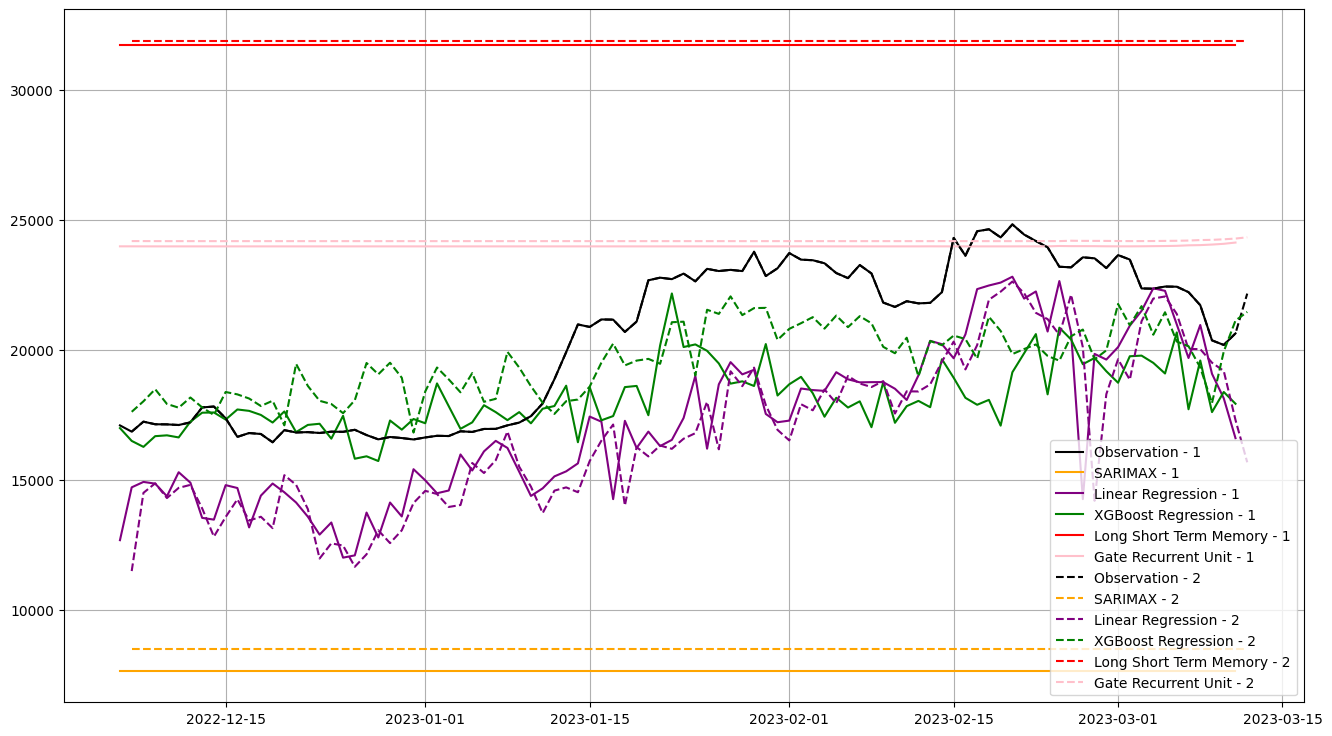

In [83]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.plot(df_0['Y_test'], 'black', label='Observation - 1')
plt.plot(df_0['Y_SARIMAX'], 'orange', label='SARIMAX - 1')
plt.plot(df_0["Y_LR"], 'purple', label=f'Linear Regression - 1')
plt.plot(df_0["Y_XGBR"], 'green', label=f'XGBoost Regression - 1')
plt.plot(df_0["Y_LSTM"], 'red', label=f'Long Short Term Memory - 1')
plt.plot(df_0["Y_GRU"], 'pink', label=f'Gate Recurrent Unit - 1')
plt.plot(df_1['Y_test'], 'black', label='Observation - 2', linestyle='dashed')
plt.plot(df_1['Y_SARIMAX'], 'orange', label='SARIMAX - 2', linestyle='dashed')
plt.plot(df_1["Y_LR"], 'purple', label=f'Linear Regression - 2', linestyle='dashed')
plt.plot(df_1["Y_XGBR"], 'green', label=f'XGBoost Regression - 2', linestyle='dashed')
plt.plot(df_1["Y_LSTM"], 'red', label=f'Long Short Term Memory - 2', linestyle='dashed')
plt.plot(df_1["Y_GRU"], 'pink', label=f'Gate Recurrent Unit - 2', linestyle='dashed')
plt.legend()
plt.savefig(f'G:/My Drive/IS6102.CH1701/Result/Image/{T1}_{TF2}.png')

## Save Model

In [73]:
from tensorflow.keras.models import load_model

In [17]:
import pickle
# Other
sarimax_filename_0 =  f'G:/My Drive/IS6102.CH1701/Result/Model/sarimax_original_{T1}_{TF2}_0.h5'
pickle.dump(sarimax_fit_0, open(sarimax_filename_0, 'wb'))
sarimax_filename_1 = f'G:/My Drive/IS6102.CH1701/Result/Model/sarimax_original_{T1}_{TF2}_1.h5'
pickle.dump(sarimax_fit_1, open(sarimax_filename_1, 'wb'))
lr_filename = f'G:/My Drive/IS6102.CH1701/Result/Model/lr_original_{T1}_{TF2}.h5'
pickle.dump(lr_mod, open(lr_filename, 'wb'))
xgbr_filename = f'G:/My Drive/IS6102.CH1701/Result/Model/xgbr_original_{T1}_{TF2}.h5'
pickle.dump(xgbr_mod, open(xgbr_filename, 'wb'))
#### Keras
lstm_mod.save(f'G:/My Drive/IS6102.CH1701/Result/Model/lstm_original_{T1}_{TF2}.h5')
gru_mod.save(f'G:/My Drive/IS6102.CH1701/Result/Model/gru_original_{T1}_{TF2}.h5')

# Draft

In [19]:
from tensorflow.keras.models import load_model

In [20]:
import pickle
# Other
sarimax_filename_0 =  f'G:/My Drive/IS6102.CH1701/Result/Model/sarimax_original_{T1}_{TF2}_0.h5'
sarimax_mod_0 = pickle.load(open(sarimax_filename_0, 'rb'))
sarimax_filename_1 = f'G:/My Drive/IS6102.CH1701/Result/Model/sarimax_original_{T1}_{TF2}_1.h5'
sarimax_mod_1 = pickle.load(open(sarimax_filename_1, 'rb'))
lr_filename = f'G:/My Drive/IS6102.CH1701/Result/Model/lr_original_{T1}_{TF2}.h5'
lr_mod = pickle.load(open(lr_filename, 'rb'))
xgbr_filename = f'G:/My Drive/IS6102.CH1701/Result/Model/xgbr_original_{T1}_{TF2}.h5'
xgbr_mod = pickle.load(open(xgbr_filename, 'rb'))
#### Keras
lstm_mod = load_model(f'G:/My Drive/IS6102.CH1701/Result/Model/lstm_original_{T1}_{TF2}.h5')
gru_mod = load_model(f'G:/My Drive/IS6102.CH1701/Result/Model/gru_original_{T1}_{TF2}.h5')

In [21]:
import joblib
scaler_single_filename = "G:/My Drive/IS6102.CH1701/Result/Dataset/scaler_single.save"
scaler_single = joblib.load(scaler_single_filename) 

In [22]:
y16_original_minmax_train_0, y16_original_minmax_train_1 = split_y_y(y16_original_minmax_train)
y16_original_minmax_test_0, y16_original_minmax_test_1 = split_y_y(y16_original_minmax_test)

In [23]:
sarimax_pred_0 = sarimax_mod_0.predict(start = 1, end = len(y16_original_minmax_test_0), exog = x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
sarimax_pred_1 = sarimax_mod_1.predict(start = 1, end = len(y16_original_minmax_test_1),exog = x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
lr_pred = lr_mod.predict(x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
xgbr_pred = xgbr_mod.predict(x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
lstm_pred = lstm_mod.predict(x16_original_minmax_test)
gru_pred = gru_mod.predict(x16_original_minmax_test)

3/3 [==============================] - 0s 6ms/step


In [24]:
y_test_inv = []
for i in range(0, len(y16_original_minmax_test)):
    y_test_inv.append(scaler_single.inverse_transform(y16_original_minmax_test[i].reshape(-1, 1)))
y_test_inv = np.array(y_test_inv).reshape(len(y16_original_minmax_test), 2)
y_sarima_inv = []
for i in range(0, len(sarimax_pred_0)):
    y_sarima_inv.append(scaler_single.inverse_transform(np.array([sarimax_pred_0[0], sarimax_pred_1[0]]).reshape(-1, 1)))
y_sarima_inv = np.array(y_sarima_inv).reshape(len(sarimax_pred_0), 2)
y_lr_inv = []
for i in range(0, len(lr_pred)):
    y_lr_inv.append(scaler_single.inverse_transform(lr_pred[i].reshape(-1, 1)))
y_lr_inv = np.array(y_lr_inv).reshape(len(lr_pred), 2)
y_xgbr_inv = []
for i in range(0, len(xgbr_pred)):
    y_xgbr_inv.append(scaler_single.inverse_transform(xgbr_pred[i].reshape(-1, 1)))
y_xgbr_inv = np.array(y_xgbr_inv).reshape(len(xgbr_pred), 2)
y_lstm_inv = []
for i in range(0, len(lstm_pred)):
    y_lstm_inv.append(scaler_single.inverse_transform(lstm_pred[i].reshape(-1, 1)))
y_lstm_inv = np.array(y_lstm_inv).reshape(len(lstm_pred), 2)
y_gru_inv = []
for i in range(0, len(gru_pred)):
    y_gru_inv.append(scaler_single.inverse_transform(gru_pred[i].reshape(-1, 1)))
y_gru_inv = np.array(y_gru_inv).reshape(len(gru_pred), 2)

In [25]:
y_test_inv_0, y_test_inv_1 = split_y_y(y_test_inv)
y_sarima_inv_0, y_sarima_inv_1 = split_y_y(y_sarima_inv)
y_lr_inv_0, y_lr_inv_1 = split_y_y(y_lr_inv)
y_xgbr_inv_0, y_xgbr_inv_1 = split_y_y(y_xgbr_inv)
y_lstm_inv_0, y_lstm_inv_1 = split_y_y(y_lstm_inv)
y_gru_inv_0, y_gru_inv_1 = split_y_y(y_gru_inv)


In [26]:
date_index = np.array(df_normalize.index)
print(type(date_index))
date_index = date_index.reshape(-1, 1)
date_index


<class 'numpy.ndarray'>


array([['2020-03-12T00:00:00.000000000'],
       ['2020-03-13T00:00:00.000000000'],
       ['2020-03-14T00:00:00.000000000'],
       ...,
       ['2023-03-10T00:00:00.000000000'],
       ['2023-03-11T00:00:00.000000000'],
       ['2023-03-12T00:00:00.000000000']], dtype='datetime64[ns]')

In [27]:
date_array = []
for t in range(len(date_index) - T1 - TF2 + 1):
    date_value = date_index[t + T1 : t + T1 + TF2, :]
    date_array.append(date_value)
date_array = np.array(date_array).reshape(len(date_array), TF2)
print("date.shape", date_array.shape) 


date.shape (1065, 2)


In [41]:
date_test = date_array[-NTest:]
date_test

array([['2022-12-07T00:00:00.000000000', '2022-12-08T00:00:00.000000000'],
       ['2022-12-08T00:00:00.000000000', '2022-12-09T00:00:00.000000000'],
       ['2022-12-09T00:00:00.000000000', '2022-12-10T00:00:00.000000000'],
       ['2022-12-10T00:00:00.000000000', '2022-12-11T00:00:00.000000000'],
       ['2022-12-11T00:00:00.000000000', '2022-12-12T00:00:00.000000000'],
       ['2022-12-12T00:00:00.000000000', '2022-12-13T00:00:00.000000000'],
       ['2022-12-13T00:00:00.000000000', '2022-12-14T00:00:00.000000000'],
       ['2022-12-14T00:00:00.000000000', '2022-12-15T00:00:00.000000000'],
       ['2022-12-15T00:00:00.000000000', '2022-12-16T00:00:00.000000000'],
       ['2022-12-16T00:00:00.000000000', '2022-12-17T00:00:00.000000000'],
       ['2022-12-17T00:00:00.000000000', '2022-12-18T00:00:00.000000000'],
       ['2022-12-18T00:00:00.000000000', '2022-12-19T00:00:00.000000000'],
       ['2022-12-19T00:00:00.000000000', '2022-12-20T00:00:00.000000000'],
       ['2022-12-20T00:00

In [42]:
date_test_0, date_test_1 = split_y_y(date_test)
print(date_test_0.shape, date_test_1.shape)

(96,) (96,)


In [43]:
detail_sarima_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_SARIMAX": y_sarima_inv_0
}
df_sarima_0 = pd.DataFrame(detail_sarima_0, columns = ["Date", "Y_test","Y_SARIMAX"])
# df_sarima_0.set_index("Date", inplace = True)
# df_sarima_0.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_1/{T1}_days_{TF2}_day_SARIMAX.csv")

In [44]:
detail_sarima_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_SARIMAX": y_sarima_inv_1
}
df_sarima_1 = pd.DataFrame(detail_sarima_1, columns = ["Date", "Y_test","Y_SARIMAX"])
# df_sarima_1.set_index("Date", inplace = True)
# df_sarima_1.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_2/{T1}_days_{TF2}_day_SARIMAX.csv")

In [45]:
df_sarimax = pd.merge(df_sarima_0[['Date', 'Y_test', 'Y_SARIMAX']], df_sarima_1[['Date', 'Y_SARIMAX']], on = "Date", how = "outer")
df_sarimax.rename(columns = {'Y_SARIMAX_x':'Furture - 1', 'Y_SARIMAX_y':'Furture - 2'}, inplace = True)
# df_sarimax.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days/{T1}_days_{TF2}_day_SARIMAX.csv")

In [46]:
detail_LR_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_LR": y_lr_inv_0
}
df_LR_0 = pd.DataFrame(detail_LR_0, columns = ["Date", "Y_test","Y_LR"])
# df_LR_0.set_index("Date", inplace = True)
# df_LR_0.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_1/{T1}_days_{TF2}_day_LR.csv")

In [49]:
detail_LR_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_LR": y_lr_inv_1
}
df_LR_1 = pd.DataFrame(detail_LR_1, columns = ["Date", "Y_test","Y_LR"])
# df_LR_1.set_index("Date", inplace = True)
# df_LR_1.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_2/{T1}_days_{TF2}_day_LR.csv")

In [48]:
df_LR = pd.merge(df_LR_0[['Date', 'Y_test', 'Y_LR']], df_LR_1[['Date', 'Y_LR']], on = "Date", how = "outer")
df_LR.rename(columns = {'Y_LR_x':'Furture - 1', 'Y_LR_y':'Furture - 2'}, inplace = True)
df_LR.to_csv(f"G:/My Drive/IS6102.CH1701/Result/Truc_WebVisualization/predict_2_days/{T1}_days_{TF2}_day_LR.csv")

In [35]:
detail_XGBR_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_XGBR": y_xgbr_inv_0
}
df_XGBR_0 = pd.DataFrame(detail_XGBR_0, columns = ["Date", "Y_test","Y_XGBR"])
# df_XGBR_0.set_index("Date", inplace = True)
# df_XGBR_0.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_1/{T1}_days_{TF2}_day_XGBR.csv")

In [36]:
detail_XGBR_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_XGBR": y_xgbr_inv_1
}
df_XGBR_1 = pd.DataFrame(detail_XGBR_1, columns = ["Date", "Y_test","Y_XGBR"])
# df_XGBR_1.set_index("Date", inplace = True)
# df_XGBR_1.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_2/{T1}_days_{TF2}_day_XGBR.csv")

In [41]:
df_XGBR = pd.merge(df_XGBR_0[['Date', 'Y_test', 'Y_XGBR']], df_XGBR_1[['Date', 'Y_XGBR']], on = "Date", how = "outer")
df_XGBR.rename(columns = {'Y_XGBR_x':'Furture - 1', 'Y_XGBR_y':'Furture - 2'}, inplace = True)
df_XGBR.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days/{T1}_days_{TF2}_day_XGBR.csv")

In [37]:
detail_LSTM_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_LSTM": y_lstm_inv_0
}
df_LSTM_0 = pd.DataFrame(detail_LSTM_0, columns = ["Date", "Y_test","Y_LSTM"])
# df_LSTM_0.set_index("Date", inplace = True)
# df_LSTM_0.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_1/{T1}_days_{TF2}_day_LSTM.csv")

In [42]:
detail_LSTM_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_LSTM": y_lstm_inv_1
}
df_LSTM_1 = pd.DataFrame(detail_LSTM_1, columns = ["Date", "Y_test","Y_LSTM"])
# df_LSTM_1.set_index("Date", inplace = True)
# df_LSTM_1.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_2/{T1}_days_{TF2}_day_LSTM.csv")

In [43]:
df_LSTM = pd.merge(df_LSTM_0[['Date', 'Y_test', 'Y_LSTM']], df_LSTM_1[['Date', 'Y_LSTM']], on = "Date", how = "outer")
df_LSTM.rename(columns = {'Y_LSTM_x':'Furture - 1', 'Y_LSTM_y':'Furture - 2'}, inplace = True)
df_LSTM.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days/{T1}_days_{TF2}_day_LSTM.csv")

In [44]:
detail_GRU_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_GRU": y_gru_inv_0
}
df_GRU_0 = pd.DataFrame(detail_GRU_0, columns = ["Date", "Y_test","Y_GRU"])
# df_GRU_0.set_index("Date", inplace = True)
# df_GRU_0.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_1/{T1}_days_{TF2}_day_GRU.csv")

In [45]:
detail_GRU_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_GRU": y_gru_inv_1
}
df_GRU_1 = pd.DataFrame(detail_GRU_1, columns = ["Date", "Y_test","Y_GRU"])
# df_GRU_1.set_index("Date", inplace = True)
# df_GRU_1.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_2/{T1}_days_{TF2}_day_GRU.csv")

In [46]:
df_GRU = pd.merge(df_GRU_0[['Date', 'Y_test', 'Y_GRU']], df_GRU_1[['Date', 'Y_GRU']], on = "Date", how = "outer")
df_GRU.rename(columns = {'Y_GRU_x':'Furture - 1', 'Y_GRU_y':'Furture - 2'}, inplace = True)
df_GRU.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days/{T1}_days_{TF2}_day_GRU.csv")

In [40]:
detail_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_SARIMAX": y_sarima_inv_0,
    "Y_LR": y_lr_inv_0,
    "Y_XGBR": y_xgbr_inv_0,
    "Y_LSTM": y_lstm_inv_0,
    "Y_GRU": y_gru_inv_0
}
df_0 = pd.DataFrame(detail_0, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df_0.set_index("Date", inplace = True)
df_0.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_1/{T1}_days_{TF2}_day_ALL.csv")

In [41]:
detail_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_SARIMAX": y_sarima_inv_1,
    "Y_LR": y_lr_inv_1,
    "Y_XGBR": y_xgbr_inv_1,
    "Y_LSTM": y_lstm_inv_1,
    "Y_GRU": y_gru_inv_1
}
df_1 = pd.DataFrame(detail_1, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df_1.set_index("Date", inplace = True)
df_1.to_csv(f"G:/My Drive/IS6102.CH1701/Result/VisualizeCuaTruc/predict_2_days_2/{T1}_days_{TF2}_day_ALL.csv")

# Draft

In [50]:
from tensorflow.keras.models import load_model

In [51]:
import pickle
# Other
sarimax_filename_0 =  f'G:/My Drive/IS6102.CH1701/Result/Model/sarimax_original_{T1}_{TF2}_0.h5'
sarimax_mod_0 = pickle.load(open(sarimax_filename_0, 'rb'))
sarimax_filename_1 = f'G:/My Drive/IS6102.CH1701/Result/Model/sarimax_original_{T1}_{TF2}_1.h5'
sarimax_mod_1 = pickle.load(open(sarimax_filename_1, 'rb'))
lr_filename = f'G:/My Drive/IS6102.CH1701/Result/Model/lr_original_{T1}_{TF2}.h5'
lr_mod = pickle.load(open(lr_filename, 'rb'))
xgbr_filename = f'G:/My Drive/IS6102.CH1701/Result/Model/xgbr_original_{T1}_{TF2}.h5'
xgbr_mod = pickle.load(open(xgbr_filename, 'rb'))
#### Keras
lstm_mod = load_model(f'G:/My Drive/IS6102.CH1701/Result/Model/lstm_original_{T1}_{TF2}.h5')
gru_mod = load_model(f'G:/My Drive/IS6102.CH1701/Result/Model/gru_original_{T1}_{TF2}.h5')

In [52]:
import joblib
scaler_single_filename = "G:/My Drive/IS6102.CH1701/Result/Dataset/scaler_single.save"
scaler_single = joblib.load(scaler_single_filename) 

In [53]:
y16_original_minmax_train_0, y16_original_minmax_train_1 = split_y_y(y16_original_minmax_train)
y16_original_minmax_test_0, y16_original_minmax_test_1 = split_y_y(y16_original_minmax_test)

In [54]:
sarimax_pred_0 = sarimax_mod_0.predict(start = 1, end = len(y16_original_minmax_test_0), exog = x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
sarimax_pred_1 = sarimax_mod_1.predict(start = 1, end = len(y16_original_minmax_test_1),exog = x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
lr_pred = lr_mod.predict(x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
xgbr_pred = xgbr_mod.predict(x16_original_minmax_test.reshape(len(x16_original_minmax_test),NFeature*T1))
lstm_pred = lstm_mod.predict(x16_original_minmax_test)
gru_pred = gru_mod.predict(x16_original_minmax_test)

3/3 [==============================] - 0s 5ms/step


In [55]:
y_test_inv = []
for i in range(0, len(y16_original_minmax_test)):
    y_test_inv.append(scaler_single.inverse_transform(y16_original_minmax_test[i].reshape(-1, 1)))
y_test_inv = np.array(y_test_inv).reshape(len(y16_original_minmax_test), 2)
y_sarima_inv = []
for i in range(0, len(sarimax_pred_0)):
    y_sarima_inv.append(scaler_single.inverse_transform(np.array([sarimax_pred_0[0], sarimax_pred_1[0]]).reshape(-1, 1)))
y_sarima_inv = np.array(y_sarima_inv).reshape(len(sarimax_pred_0), 2)
y_lr_inv = []
for i in range(0, len(lr_pred)):
    y_lr_inv.append(scaler_single.inverse_transform(lr_pred[i].reshape(-1, 1)))
y_lr_inv = np.array(y_lr_inv).reshape(len(lr_pred), 2)
y_xgbr_inv = []
for i in range(0, len(xgbr_pred)):
    y_xgbr_inv.append(scaler_single.inverse_transform(xgbr_pred[i].reshape(-1, 1)))
y_xgbr_inv = np.array(y_xgbr_inv).reshape(len(xgbr_pred), 2)
y_lstm_inv = []
for i in range(0, len(lstm_pred)):
    y_lstm_inv.append(scaler_single.inverse_transform(lstm_pred[i].reshape(-1, 1)))
y_lstm_inv = np.array(y_lstm_inv).reshape(len(lstm_pred), 2)
y_gru_inv = []
for i in range(0, len(gru_pred)):
    y_gru_inv.append(scaler_single.inverse_transform(gru_pred[i].reshape(-1, 1)))
y_gru_inv = np.array(y_gru_inv).reshape(len(gru_pred), 2)

In [56]:
y_test_inv_0, y_test_inv_1 = split_y_y(y_test_inv)
y_sarima_inv_0, y_sarima_inv_1 = split_y_y(y_sarima_inv)
y_lr_inv_0, y_lr_inv_1 = split_y_y(y_lr_inv)
y_xgbr_inv_0, y_xgbr_inv_1 = split_y_y(y_xgbr_inv)
y_lstm_inv_0, y_lstm_inv_1 = split_y_y(y_lstm_inv)
y_gru_inv_0, y_gru_inv_1 = split_y_y(y_gru_inv)

In [57]:
date_index = np.array(df_normalize.index)
print(type(date_index))
date_index = date_index.reshape(-1, 1)
date_index


<class 'numpy.ndarray'>


array([['2020-03-12T00:00:00.000000000'],
       ['2020-03-13T00:00:00.000000000'],
       ['2020-03-14T00:00:00.000000000'],
       ...,
       ['2023-03-10T00:00:00.000000000'],
       ['2023-03-11T00:00:00.000000000'],
       ['2023-03-12T00:00:00.000000000']], dtype='datetime64[ns]')

In [58]:
date_array = []
for t in range(len(date_index) - T1 - TF2 + 1):
    date_value = date_index[t + T1 : t + T1 + TF2, :]
    date_array.append(date_value)
date_array = np.array(date_array).reshape(len(date_array), TF2)
print("date.shape", date_array.shape) 


date.shape (1065, 2)


In [59]:
i = 0
while i < TF2:
    if i == 0:
        a = np.array(date_array[-1][0] + np.timedelta64(1,'D'))
    else:
        a = np.append(a, date_array[-1][i] + np.timedelta64(1,'D')) 
    i = i + 1
a = a.reshape(1, -TF2)
a.shape
date_array = np.append(date_array, a)
date_array = date_array.reshape(int(len(date_array)/2), 2)
date_array[-1]

array(['2023-03-12T00:00:00.000000000', '2023-03-13T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [60]:
date_test = date_array[-NTest:]
date_test

array([['2022-12-07T00:00:00.000000000', '2022-12-08T00:00:00.000000000'],
       ['2022-12-08T00:00:00.000000000', '2022-12-09T00:00:00.000000000'],
       ['2022-12-09T00:00:00.000000000', '2022-12-10T00:00:00.000000000'],
       ['2022-12-10T00:00:00.000000000', '2022-12-11T00:00:00.000000000'],
       ['2022-12-11T00:00:00.000000000', '2022-12-12T00:00:00.000000000'],
       ['2022-12-12T00:00:00.000000000', '2022-12-13T00:00:00.000000000'],
       ['2022-12-13T00:00:00.000000000', '2022-12-14T00:00:00.000000000'],
       ['2022-12-14T00:00:00.000000000', '2022-12-15T00:00:00.000000000'],
       ['2022-12-15T00:00:00.000000000', '2022-12-16T00:00:00.000000000'],
       ['2022-12-16T00:00:00.000000000', '2022-12-17T00:00:00.000000000'],
       ['2022-12-17T00:00:00.000000000', '2022-12-18T00:00:00.000000000'],
       ['2022-12-18T00:00:00.000000000', '2022-12-19T00:00:00.000000000'],
       ['2022-12-19T00:00:00.000000000', '2022-12-20T00:00:00.000000000'],
       ['2022-12-20T00:00

In [61]:
date_test_0, date_test_1 = split_y_y(date_test)
print(date_test_0.shape, date_test_1.shape)

(96,) (96,)


In [62]:
new_date = date_test_0.copy()
new_date = np.append(new_date, date_test_1[-1])
new_date.shape

(97,)

In [63]:
new_y_test = y_test_inv_0.copy()
new_y_test = np.append(new_y_test, y_test_inv_1[-1])
new_y_test.shape

(97,)

In [64]:
new_y_sarima = y_sarima_inv_0.copy()
new_y_sarima = np.append(new_y_sarima, y_sarima_inv_1[-1])
new_y_sarima.shape

(97,)

In [65]:
new_y_lr = y_lr_inv_0.copy()
new_y_lr = np.append(new_y_lr, y_lr_inv_1[-1])
new_y_lr.shape

(97,)

In [66]:
new_y_xgbr = y_xgbr_inv_0.copy()
new_y_xgbr = np.append(new_y_xgbr, y_xgbr_inv_1[-1])
new_y_xgbr.shape

(97,)

In [67]:
new_y_lstm = y_lstm_inv_0.copy()
new_y_lstm = np.append(new_y_lstm, y_lstm_inv_1[-1])
new_y_lstm.shape

(97,)

In [68]:
new_y_gru = y_gru_inv_0.copy()
new_y_gru = np.append(new_y_gru, y_gru_inv_1[-1])
new_y_gru.shape

(97,)

In [69]:
detail = {
    "Date" : new_date,
    "Y_test": new_y_test,
    "Y_SARIMAX": new_y_sarima,
    "Y_LR": new_y_lr,
    "Y_XGBR": new_y_xgbr,
    "Y_LSTM": new_y_lstm,
    "Y_GRU": new_y_gru
}
df = pd.DataFrame(detail, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df.set_index("Date", inplace = True)
df.head(5)

,Y_test,Y_SARIMAX,Y_LR,Y_XGBR,Y_LSTM,Y_GRU
Date,,,,,,
2022-12-07,17089.503906,7640.852818,12669.886474,16985.013672,31735.570312,23984.148438
2022-12-08,16848.126953,7640.852818,14704.627849,16491.841797,31735.570312,23983.910156
2022-12-09,17233.474609,7640.852818,14912.509280,16262.500977,31735.570312,23982.994141
2022-12-10,17133.152344,7640.852818,14847.104849,16674.646484,31735.570312,23982.574219
2022-12-11,17128.724609,7640.852818,14359.507172,16706.830078,31735.570312,23982.574219


In [70]:
check = df.copy()
check.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2022-12-07 to 2023-03-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y_test     97 non-null     float64
 1   Y_SARIMAX  97 non-null     float64
 2   Y_LR       97 non-null     float64
 3   Y_XGBR     97 non-null     float32
 4   Y_LSTM     97 non-null     float32
 5   Y_GRU      97 non-null     float32
dtypes: float32(3), float64(3)
memory usage: 4.2 KB


In [71]:
detail_0 = {
    "Date" : date_test_0,
    "Y_test": y_test_inv_0,
    "Y_SARIMAX": y_sarima_inv_0,
    "Y_LR": y_lr_inv_0,
    "Y_XGBR": y_xgbr_inv_0,
    "Y_LSTM": y_lstm_inv_0,
    "Y_GRU": y_gru_inv_0
}
df_0 = pd.DataFrame(detail_0, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df_0.set_index("Date", inplace = True)
df_0.head(5)

,Y_test,Y_SARIMAX,Y_LR,Y_XGBR,Y_LSTM,Y_GRU
Date,,,,,,
2022-12-07,17089.503906,7640.852818,12669.886474,16985.013672,31735.570312,23984.148438
2022-12-08,16848.126953,7640.852818,14704.627849,16491.841797,31735.570312,23983.910156
2022-12-09,17233.474609,7640.852818,14912.509280,16262.500977,31735.570312,23982.994141
2022-12-10,17133.152344,7640.852818,14847.104849,16674.646484,31735.570312,23982.574219
2022-12-11,17128.724609,7640.852818,14359.507172,16706.830078,31735.570312,23982.574219


In [72]:
detail_1 = {
    "Date" : date_test_1,
    "Y_test": y_test_inv_1,
    "Y_SARIMAX": y_sarima_inv_1,
    "Y_LR": y_lr_inv_1,
    "Y_XGBR": y_xgbr_inv_1,
    "Y_LSTM": y_lstm_inv_1,
    "Y_GRU": y_gru_inv_1
}
df_1 = pd.DataFrame(detail_1, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df_1.set_index("Date", inplace = True)
df_1.head(5)

,Y_test,Y_SARIMAX,Y_LR,Y_XGBR,Y_LSTM,Y_GRU
Date,,,,,,
2022-12-08,16848.126953,8476.90647,11480.576921,17612.662109,31899.277344,24186.507812
2022-12-09,17233.474609,8476.90647,14491.901548,18017.271484,31899.277344,24186.269531
2022-12-10,17133.152344,8476.90647,14859.575794,18482.927734,31899.277344,24185.353516
2022-12-11,17128.724609,8476.90647,14291.320619,17915.396484,31899.277344,24184.929688
2022-12-12,17104.193359,8476.90647,14683.679962,17771.048828,31899.277344,24184.929688


In [73]:
avg_sarimax = []
avg_lr = []
avg_xgbr = []
avg_lstm = []
avg_gru = []
for index, row in check.iterrows():
  print(index)
  if len(df_1['Y_SARIMAX'].loc[df_1.index == index].values) == 0:
    avg_sarimax.append(np.array([row["Y_SARIMAX"]]))
    avg_lr.append(np.array([row["Y_LR"]]))
    avg_xgbr.append(np.array([row["Y_XGBR"]]))
    avg_lstm.append(np.array([row["Y_LSTM"]]))
    avg_gru.append(np.array([row["Y_GRU"]]))
  else:
    avg_sarimax.append((df_1['Y_SARIMAX'].loc[df_1.index == index].values + np.array(row["Y_SARIMAX"])) / 2)
    avg_lr.append((df_1['Y_LR'].loc[df_1.index == index].values + np.array(row["Y_LR"])) / 2)
    avg_xgbr.append((df_1['Y_XGBR'].loc[df_1.index == index].values + np.array(row["Y_XGBR"])) / 2)
    avg_lstm.append((df_1['Y_LSTM'].loc[df_1.index == index].values + np.array(row["Y_LSTM"])) / 2)
    avg_gru.append((df_1['Y_GRU'].loc[df_1.index == index].values + np.array(row["Y_GRU"])) / 2) 

2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00
2022-12-10 00:00:00
2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-17 00:00:00
2022-12-18 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00
2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00
2022-12-31 00:00:00
2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-21 00:00:00
2023-01-22 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00


In [74]:
avg_sarimax = np.array(avg_sarimax).reshape(len(np.array(avg_sarimax)), )
avg_lr = np.array(avg_lr).reshape(len(np.array(avg_lr)), )
avg_xgbr = np.array(avg_xgbr).reshape(len(np.array(avg_xgbr)), )
avg_lstm = np.array(avg_lstm).reshape(len(np.array(avg_lstm)), )
avg_gru = np.array(avg_gru).reshape(len(np.array(avg_gru)), )

In [75]:
detail_avg = {
    "Date" : new_date,
    "Y_test": new_y_test,
    "Y_SARIMAX": avg_sarimax,
    "Y_LR": avg_lr,
    "Y_XGBR": avg_xgbr,
    "Y_LSTM": avg_lstm,
    "Y_GRU": avg_gru
}
df_avg = pd.DataFrame(detail_avg, columns = ["Date", "Y_test","Y_SARIMAX", "Y_LR", "Y_XGBR", "Y_LSTM", "Y_GRU"])
df_avg.set_index("Date", inplace = True)
df_avg.head(5)

,Y_test,Y_SARIMAX,Y_LR,Y_XGBR,Y_LSTM,Y_GRU
Date,,,,,,
2022-12-07,17089.503906,7640.852818,12669.886474,16985.013672,31735.570312,23984.148438
2022-12-08,16848.126953,8058.879644,13092.602385,17052.251953,31817.423828,24085.208984
2022-12-09,17233.474609,8058.879644,14702.205414,17139.886719,31817.423828,24084.632812
2022-12-10,17133.152344,8058.879644,14853.340321,17578.787109,31817.423828,24083.964844
2022-12-11,17128.724609,8058.879644,14325.413896,17311.113281,31817.423828,24083.751953


In [76]:
df_avg.to_csv(f"G:/My Drive/IS6102.CH1701/Result/Truc_WebVisualization/predict_2_days/{T1}_days_{TF2}_day_ALL.csv")

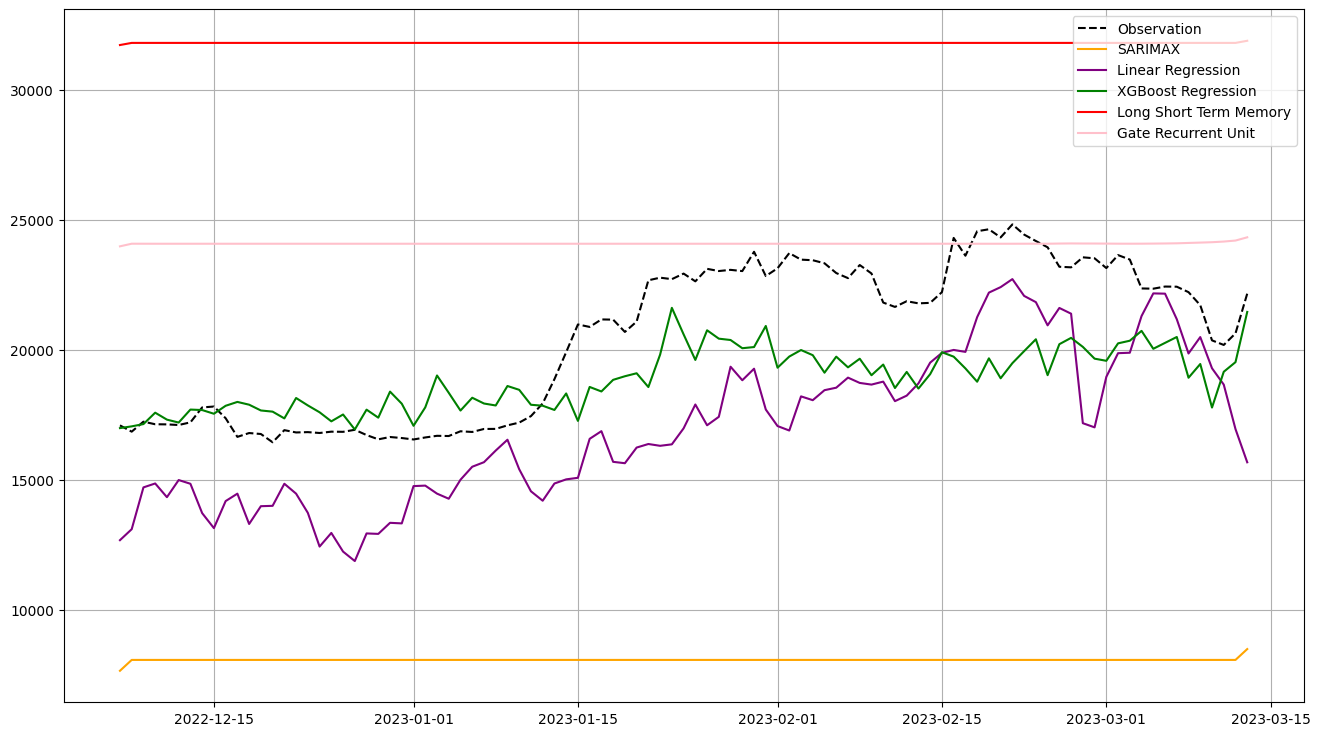

In [77]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.plot(df_avg['Y_test'], 'black', label='Observation', linestyle='dashed')
plt.plot(df_avg['Y_SARIMAX'], 'orange', label='SARIMAX')
plt.plot(df_avg["Y_LR"], 'purple', label=f'Linear Regression')
plt.plot(df_avg["Y_XGBR"], 'green', label=f'XGBoost Regression')
plt.plot(df_avg["Y_LSTM"], 'red', label=f'Long Short Term Memory')
plt.plot(df_avg["Y_GRU"], 'pink', label=f'Gate Recurrent Unit')
plt.legend()
plt.savefig(f'G:/My Drive/IS6102.CH1701/Result/Image/{T1}_{TF2}_1.png')